In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from argparse import Namespace
import tqdm.notebook

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

In [2]:
history_path = "../DropEdge/runs/run_history-dataset_cora-type_mutigcn"
history_df = pd.read_csv(history_path)
history_df.head()

,Unnamed: 0,loss_train,acc_train,loss_val,acc_val,cur_lr,s_time,t_time,v_time
0,0,2.182136,0.118377,1.854611,0.292,0.01,0.009963,0.078758,0.012475
1,1,1.964978,0.225993,1.856962,0.252,0.01,0.006585,0.046680,0.013992
2,2,1.888065,0.240066,1.867371,0.188,0.01,0.006968,0.046859,0.016717
3,3,1.875225,0.216887,1.851822,0.276,0.01,0.008421,0.044385,0.013572
4,4,1.866314,0.247517,1.819915,0.288,0.01,0.006443,0.038232,0.015398


Text(0, 0.5, 'accuracy')

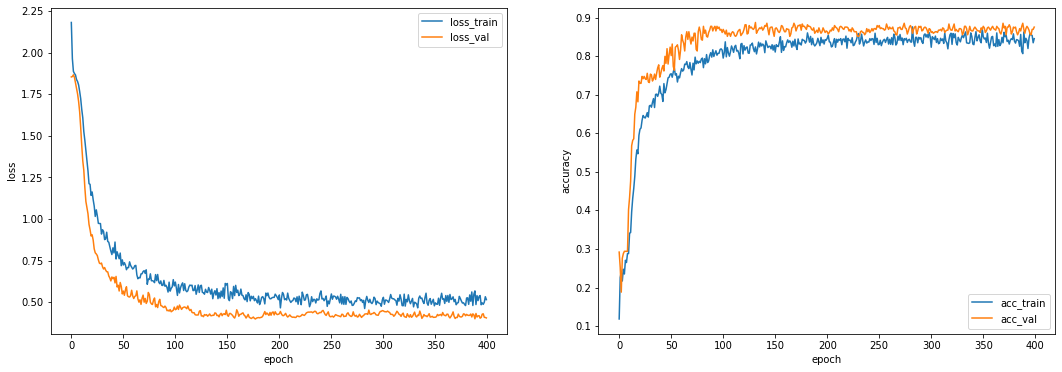

In [3]:
fig,axs = plt.subplots(1, 2, figsize=(18, 6))

history_df[['loss_train', 'loss_val']].plot(ax=axs[0])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

history_df[['acc_train', 'acc_val']].plot(ax=axs[1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [4]:
model_path = "../DropEdge/tmpmodel/tmp-0304-091554-xhP.pt"
args_path = "../DropEdge/tmpmodel/args.json"

with open(args_path, 'r') as f:
    args = json.loads(f.read())
    print("args: ", args)
    args = Namespace(**args)

args.datapath = '../DropEdge/' + args.datapath
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

sampler = Sampler(args.dataset, args.datapath, args.task_type)
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args.cuda)
nfeat = sampler.nfeat
nclass = sampler.nclass

base_model = GCNModel(nfeat=nfeat,
                      nhid=args.hidden,
                      nclass=nclass,
                      nhidlayer=args.nhiddenlayer,
                      dropout=args.dropout,
                      baseblock=args.type,
                      inputlayer=args.inputlayer,
                      outputlayer=args.outputlayer,
                      nbaselayer=args.nbaseblocklayer,
                      activation=F.relu,
                      withbn=args.withbn,
                      withloop=args.withloop,
                      aggrmethod=args.aggrmethod,
                      mixmode=args.mixmode)

if device == torch.device('cuda'):
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
base_model.load_state_dict(state_dict)
base_model.to(device)

args:  {'no_cuda': False, 'fastmode': False, 'seed': 42, 'epochs': 400, 'lr': 0.01, 'lradjust': False, 'weight_decay': 0.005, 'mixmode': False, 'warm_start': '', 'debug': True, 'dataset': 'cora', 'datapath': 'data//', 'early_stopping': 400, 'no_tensorboard': False, 'type': 'mutigcn', 'inputlayer': 'gcn', 'outputlayer': 'gcn', 'hidden': 128, 'dropout': 0.8, 'withbn': False, 'withloop': False, 'nhiddenlayer': 1, 'normalization': 'FirstOrderGCN', 'sampling_percent': 0.7, 'nbaseblocklayer': 2, 'aggrmethod': 'nores', 'task_type': 'full', 'cuda': False}
Load full supervised task.


GCNModel(
  (ingc): GraphConvolutionBS()
  (outgc): GraphConvolutionBS()
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS()
          (1): GraphConvolutionBS()
        )
      )
    )
  )
)

In [5]:
class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r):
        super(GraphConvolutionBSSVD, self).__init__()
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        U, s, V = torch.svd(orig_layer.weight)
        
        self.U = nn.Parameter(U[:, :r])
        self.s = nn.Parameter(s[:r])
        self.Vt = nn.Parameter(V.T[:r, :])
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, input, adj):
        support = torch.mm(input, self.U)
        support = support * self.s
        support = torch.mm(support, self.Vt)
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'

In [6]:
def test(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args.normalization,
    cuda= device == torch.device('cuda')
)

In [63]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
    new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    new_model.midlayer[0].model.hiddenlayers[0] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[0], r)
    new_model.midlayer[0].model.hiddenlayers[1] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[1], r)
    new_model.to(device)
    return new_model

In [64]:
base_loss_test, base_acc_test = test(base_model, test_adj, test_fea)
print(f"Loss test on base_model = {base_loss_test}\nAcc test of base_model = {base_acc_test}")

Loss test on base_model = 0.5310813188552856
Acc test of base_model = 0.859


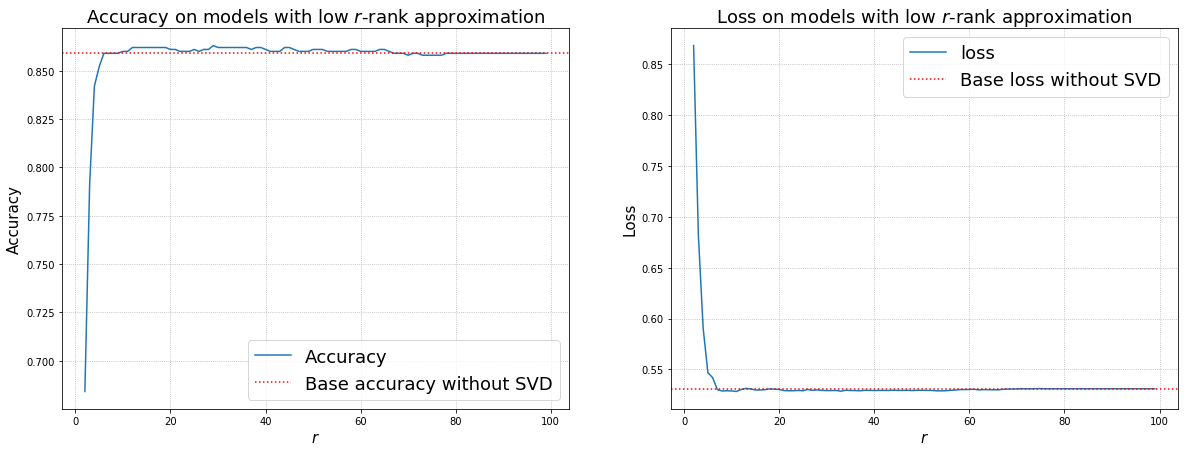

In [65]:
experiments = {
    'r': [],
    'loss': [],
    'acc': []
}

for r in tqdm.notebook.tqdm(range(2, 100)):
    model = make_new_model(base_model, r)
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['r'].append(r)
    experiments['loss'].append(loss_test)
    experiments['acc'].append(acc_test)
    del model
    
fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(experiments['r'], experiments['acc'], label='Accuracy')
axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
axs[0].legend(fontsize=18)
axs[0].set_title("Accuracy on models with low $r$-rank approximation", fontsize=18)
axs[0].set_ylabel("Accuracy", fontsize=15)
axs[0].set_xlabel("$r$", fontsize=15)
axs[0].grid(ls=":")

axs[1].plot(experiments['r'], experiments['loss'], label='loss')
axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
axs[1].legend(fontsize=18)
axs[1].set_title("Loss on models with low $r$-rank approximation", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=15)
axs[1].set_xlabel("$r$", fontsize=15)
axs[1].grid(ls=":")

In [66]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torch.optim as optim


import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from metric import accuracy
from sample import Sampler
sampler = Sampler('cora', '../DropEdge/data/', 'full')
iscuda = False
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(iscuda)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Load full supervised task.


## TODO: make early stopping

In [67]:
def fit_model(model, idx_train, idx_val, num_epochs=10, verbose=0):
    (train_adj, train_fea) = sampler.randomedge_sampler(
        percent=1.0,
        normalization='AugNormAdj',
        cuda=iscuda)
    (val_adj, val_fea) = sampler.get_val_set(normalization='AugNormAdj', cuda=iscuda)
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[5, 10, 20, 30, 40, 50],
                                               gamma=0.5)
    
    history = defaultdict(list)
    for ep in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_fea, train_adj)
        
        train_loss = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        
        train_loss.backward()
        optimizer.step()
        
        history['train_loss'].append(train_loss.item())
        history['train_acc'].append(acc_train.item())
        if verbose > 1:
            print("TRAIN: acc={:.3}; loss={:.3}".format(acc_train.item(), train_loss.item()))
        
        # Validate
        model.eval()
        output = model(val_fea, val_adj)
        val_loss = F.nll_loss(output[idx_val], labels[idx_val]).item()
        val_acc = accuracy(output[idx_val], labels[idx_val]).item()
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if verbose > 0:
            print("VALID: acc={:.3}; loss={:.3}".format(val_acc, val_loss))
        
    return history


In [68]:
# print("Loss test on base_model={:.3}, Acc test of base_model={:.3}".format(base_loss_test, base_acc_test))

# model = make_new_model(base_model, 3)
# loss_test, acc_test = test(model, test_adj, test_fea)
# print("Before fine tunning | loss_test={:.3}, acc_test={:.3}".format(loss_test, acc_test))

# # lss, accs = [], []
# # for i in range(50):
# #     fit_model(model, idx_train, 1, verbose=0)
# #     loss_test, acc_test = test(model, test_adj, test_fea)
# #     lss.append(loss_test)
# #     accs.append(acc_test)
# # # print("After fine tunning | loss_test={:.3}, acc_test={:.3}".format(loss_test, acc_test))
# history = fit_model(model, idx_train, idx_val, 100, verbose=0)


In [76]:
num_fine_tunning_batch = 18

experiments = {
    'r': [],
    'loss_before_ft': [],
    'acc_before_ft': [],
    'loss_after_ft': [],
    'acc_after_ft': []
}

ft_histories = []
for r in tqdm.notebook.tqdm(range(2, 30)):
    model = make_new_model(base_model, r)
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['r'].append(r)
    experiments['loss_before_ft'].append(loss_test)
    experiments['acc_before_ft'].append(acc_test)
    
    ft_histories.append(
        fit_model(model, idx_train, idx_val, num_fine_tunning_batch, verbose=0)
    )
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['loss_after_ft'].append(loss_test)
    experiments['acc_after_ft'].append(acc_test)
    del model

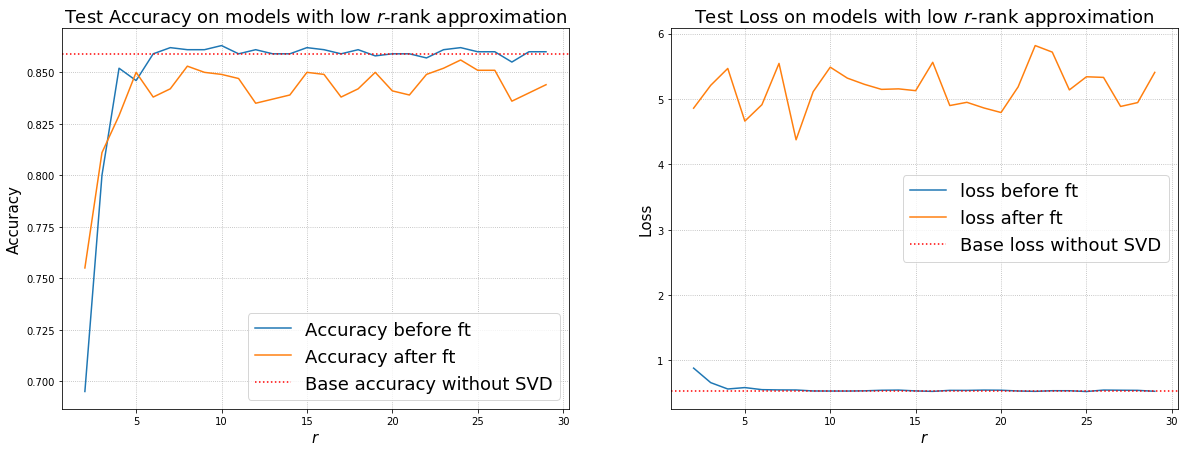

In [77]:
fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(experiments['r'], experiments['acc_before_ft'], label='Accuracy before ft')
axs[0].plot(experiments['r'], experiments['acc_after_ft'], label='Accuracy after ft')
axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
axs[0].legend(fontsize=18)
axs[0].set_title("Test Accuracy on models with low $r$-rank approximation", fontsize=18)
axs[0].set_ylabel("Accuracy", fontsize=15)
axs[0].set_xlabel("$r$", fontsize=15)
axs[0].grid(ls=":")


axs[1].plot(experiments['r'], experiments['loss_before_ft'], label='loss before ft')
axs[1].plot(experiments['r'], experiments['loss_after_ft'], label='loss after ft')
axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
axs[1].legend(fontsize=18)
axs[1].set_title("Test Loss on models with low $r$-rank approximation", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=15)
axs[1].set_xlabel("$r$", fontsize=15)
axs[1].grid(ls=":")

Text(0.5, 0, 'epoch')

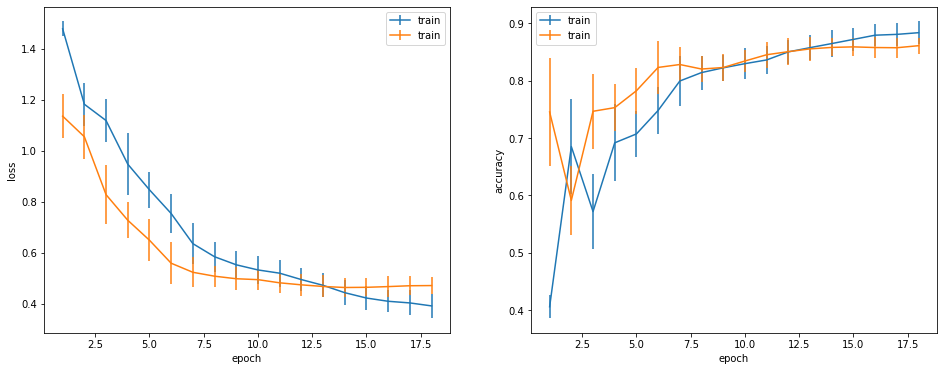

In [78]:
train_loss = np.concatenate(
    [[h['train_loss']] for h in ft_histories],
    0
)
train_acc = np.concatenate(
    [[h['train_acc']] for h in ft_histories],
    0
)
val_loss = np.concatenate(
    [[h['val_loss']] for h in ft_histories],
    0
)
val_acc = np.concatenate(
    [[h['val_acc']] for h in ft_histories],
    0
)

fix, axs = plt.subplots(1, 2, figsize=(16, 6))

xaxis = np.arange(1, len(train_loss[0])+1)

axs[0].errorbar(xaxis, np.mean(train_loss, 0), yerr=np.std(train_loss, 0), label='train')
axs[0].errorbar(xaxis, np.mean(val_loss, 0), yerr=np.std(val_loss, 0), label='train')
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].errorbar(xaxis, np.mean(train_acc, 0), yerr=np.std(train_acc, 0), label='train')
axs[1].errorbar(xaxis, np.mean(val_acc, 0), yerr=np.std(val_acc, 0), label='train')
axs[1].legend()
axs[1].set_ylabel("accuracy")
axs[1].set_xlabel("epoch")